In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs



data=[]
filePrefix="data/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue
    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

Could not load data/p0.out
([0.0, 0.1, 0.2, 0.26667, 0.2963, 0.3, 0.34783, 0.4, 0.44444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06], [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07])


In [2]:
def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData

data = removeDuplicateRuns(data)


                



Inconsistent data for 0.1, 3.0000000000000004e-07, 1.8000000000000002e-07
Inconsistent data for 0.1, 3.0000000000000004e-07, 2.0000000000000002e-07
Inconsistent data for 0.1, 3.4000000000000003e-07, 2.3000000000000002e-07
Inconsistent data for 0.1, 3.8e-07, 2.7e-07
Inconsistent data for 0.2, 3.2e-07, 2.3000000000000002e-07
Inconsistent data for 0.6, 4.0000000000000003e-07, 2.0000000000000002e-07
Fixed data for 46/505 runs. 6 runs unfixable, 0 not enough data


In [3]:


for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)>1:
                    print(pointiness,spacing,length)
                    raise Exception()

                    

In [4]:
"""
def makePlot(lengthVal,plotFunction,plotValue):
    colors=plt.cm.plasma(np.array(pointinessVals)*0.9)
    usedPointinesses=set()
    for i,pointiness in enumerate(pointinessVals):
        Hc=[]
        spacings=[]
        blackX=[]
        blackY=[]
        
        #print(pointiness - 80/(1e9*lengthVal), 80/(1e9*lengthVal), pointiness)

        for spacing in spacingVals:
            
            thisRuns=getRuns(spacing,pointiness,lengthVal)
            if len(thisRuns)==0:
                continue
            
            

            usedPointinesses.add(pointiness)
            thisRun=thisRuns[0]
            Hc.append(plotFunction(thisRun))
            spacings.append(spacing*1e9)

            
            
            if abs(pointiness - 80/(1e9*lengthVal)) < 0.01:
                
                blackX.append(spacing*1e9)
                blackY.append(plotFunction(thisRun))
                #print(blackX)

        plt.scatter(blackX,blackY,color="k",s=8,zorder=i+0.5)
        plt.plot(spacings,Hc,"o-",color=colors[i],linewidth=2,zorder=i)
        
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma",norm=mpl.colors.Normalize(vmin=0, vmax=1/0.9)))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('p', rotation=270)
    #for pointiness in list(usedPointinesses):
    #    cbar.ax.plot([0, 1], [pointiness,pointiness], 'k') 

    plt.title(f"{plotValue} vs lattice spacing (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("a (nm)")
    plt.ylabel(plotValue)
    plt.xlim(min(spacingVals)*1e9-50,max(spacingVals)*1e9+50)


    point = mpl.lines.Line2D([0], [0], label='Stadium shape', marker='o', 
    markeredgecolor='red', markerfacecolor='k', linestyle='',markeredgewidth=0)
    handles, labels = plt.gca().get_legend_handles_labels()

    handles.extend([point])

    plt.legend(handles=handles,loc="upper right").set_zorder(1000)
    plt.tight_layout()
    plt.savefig(f"(length={round(lengthVal*1e9)}nm).png")
    plt.show()
    
for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Hc"],plotValue="$H_c$")

#for lengthVal in lengthVals:
#    makePlot(lengthVal,lambda run:run.attrs["Br"],plotValue="$M_r$")

#for lengthVal in lengthVals:
#    makePlot(lengthVal,lambda run:np.min(run["hIsland_my"]),plotValue="min $m_y$")
"""

'\ndef makePlot(lengthVal,plotFunction,plotValue):\n    colors=plt.cm.plasma(np.array(pointinessVals)*0.9)\n    usedPointinesses=set()\n    for i,pointiness in enumerate(pointinessVals):\n        Hc=[]\n        spacings=[]\n        blackX=[]\n        blackY=[]\n        \n        #print(pointiness - 80/(1e9*lengthVal), 80/(1e9*lengthVal), pointiness)\n\n        for spacing in spacingVals:\n            \n            thisRuns=getRuns(spacing,pointiness,lengthVal)\n            if len(thisRuns)==0:\n                continue\n            \n            \n\n            usedPointinesses.add(pointiness)\n            thisRun=thisRuns[0]\n            Hc.append(plotFunction(thisRun))\n            spacings.append(spacing*1e9)\n\n            \n            \n            if abs(pointiness - 80/(1e9*lengthVal)) < 0.01:\n                \n                blackX.append(spacing*1e9)\n                blackY.append(plotFunction(thisRun))\n                #print(blackX)\n\n        plt.scatter(blackX,blackY,co

In [5]:
"""cmap = plt.cm.viridis

c=0.95
colorMax=700e-9

def makePlot(lengthVal,plotFunction,plotValue):

    def spacingToColor(spacings):
        temp=np.array(spacings)
        #temp[temp>colorMax]=colorMax
        #return (temp-min(spacingVals))/max(temp)
        #print(temp)
        temp[temp>colorMax]=colorMax
        return (temp-min(spacingVals))/(max(temp)-min(spacingVals))*c
    
    colors=cmap(spacingToColor(spacingVals))
    print(spacingToColor(spacingVals))
    
    usedSpacings=set()
    for i,spacing in enumerate(spacingVals):
        Hc=[]
        pointinesses=[]
        blackX=[]
        blackY=[]
        
        for pointiness in pointinessVals:
            
            thisRuns=getRuns(spacing,pointiness,lengthVal)
            if len(thisRuns)==0:
                continue
            usedSpacings.add(spacing)
            thisRun=thisRuns[0]
            Hc.append(plotFunction(thisRun))
            pointinesses.append(pointiness)

            
            
            if abs(pointiness - 80/(1e9*lengthVal)) <0.001:
                
                blackX.append(pointiness)
                blackY.append(plotFunction(thisRun))
                #print(blackX)

        plt.scatter(blackX,blackY,color="k",s=8,zorder=i+0.5)
        plt.plot(pointinesses,Hc,"o-",color=colors[i],linewidth=2,zorder=i)
        
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap,
        norm=mpl.colors.Normalize(vmin=min(spacingVals)*1e9/c,vmax=max(spacingVals)*1e9/c)
    ))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('a(nm)', rotation=270)


    plt.title(f"{plotValue} vs pointiness (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("p")
    plt.ylabel(plotValue)


    point = mpl.lines.Line2D([0], [0], label='Stadium shape', marker='o', 
    markeredgecolor='red', markerfacecolor='k', linestyle='',markeredgewidth=0)
    handles, labels = plt.gca().get_legend_handles_labels()

    handles.extend([point])

    plt.legend(handles=handles)
    plt.tight_layout()
    plt.savefig(f"(length={round(lengthVal*1e9)}nm).png")
    plt.show()
    
for lengthVal in lengthVals:
    makePlot(lengthVal,lambda run:run.attrs["Hc"],plotValue="$H_c$")

#for lengthVal in lengthVals:
#    makePlot(lengthVal,lambda run:run.attrs["Br"],plotValue="$M_r$")

#for lengthVal in lengthVals:
#    makePlot(lengthVal,lambda run:np.min(run["hIsland_my"]), plotValue="min $m_y$")
"""

'cmap = plt.cm.viridis\n\nc=0.95\ncolorMax=700e-9\n\ndef makePlot(lengthVal,plotFunction,plotValue):\n\n    def spacingToColor(spacings):\n        temp=np.array(spacings)\n        #temp[temp>colorMax]=colorMax\n        #return (temp-min(spacingVals))/max(temp)\n        #print(temp)\n        temp[temp>colorMax]=colorMax\n        return (temp-min(spacingVals))/(max(temp)-min(spacingVals))*c\n    \n    colors=cmap(spacingToColor(spacingVals))\n    print(spacingToColor(spacingVals))\n    \n    usedSpacings=set()\n    for i,spacing in enumerate(spacingVals):\n        Hc=[]\n        pointinesses=[]\n        blackX=[]\n        blackY=[]\n        \n        for pointiness in pointinessVals:\n            \n            thisRuns=getRuns(spacing,pointiness,lengthVal)\n            if len(thisRuns)==0:\n                continue\n            usedSpacings.add(spacing)\n            thisRun=thisRuns[0]\n            Hc.append(plotFunction(thisRun))\n            pointinesses.append(pointiness)\n\n         

[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.725
 2.325 ]
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.725
 2.325 ]
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.725
 2.325 ]
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.725
 2.325 ]


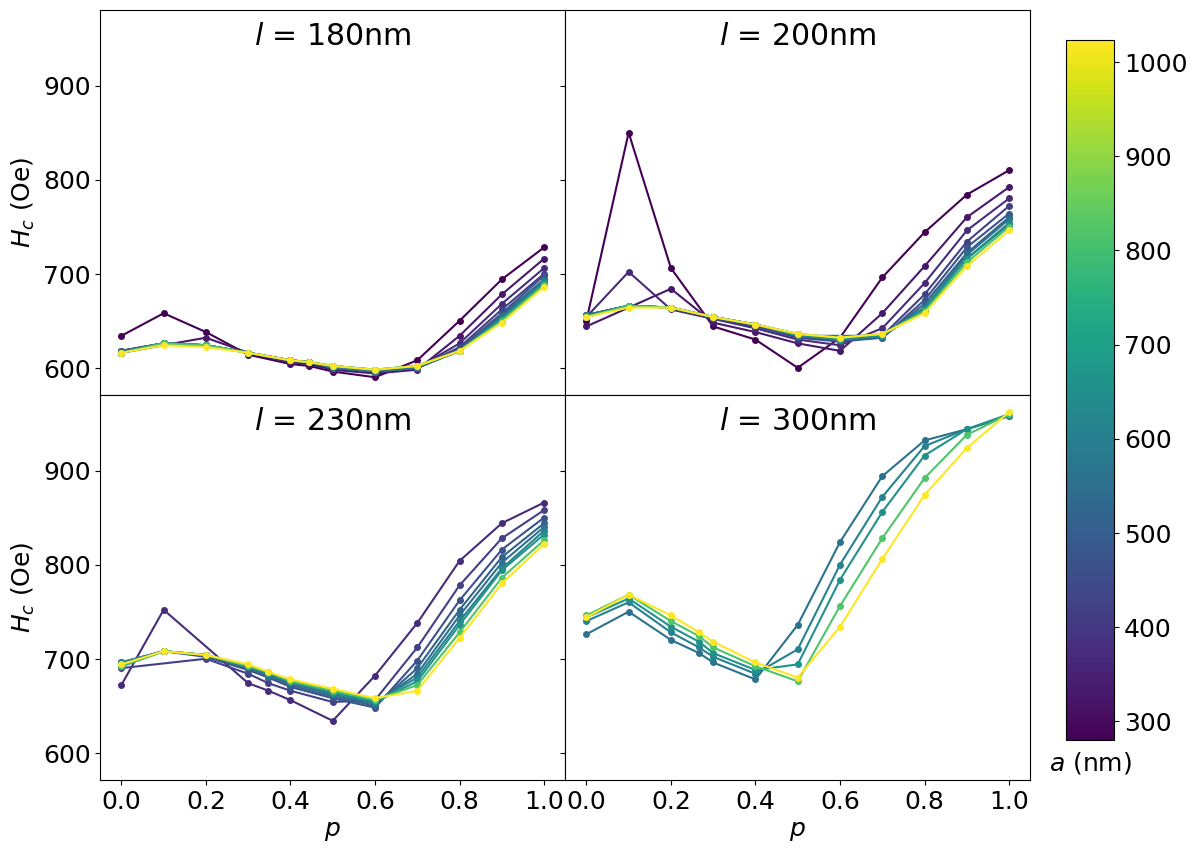

In [6]:
import pylab as pl
mpl.rcParams.update({'font.size': 18})

def makePlot(lengthVals, xItem, plotItem):

    if plotItem=="Hc":
        func = lambda run:run.attrs["Hc"]
        ylab="$H_c$ (Oe)"
    elif plotItem=="Br":
        func = lambda run:run.attrs["Br"]
        ylab="$M_r$"



    fig, axs = plt.subplots(2,2,sharey=True,sharex=True)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.04,0.7])
    fig.set_size_inches(12,10)
    plt.subplots_adjust(wspace=0, hspace=0,right=0.9)

    for plotI,lengthVal in enumerate(lengthVals):
        ax = axs.flatten()[plotI]

        stadiumX=[]
        stadiumY=[]

        if xItem=="a":
            colors=plt.cm.plasma(np.array(pointinessVals))

            for i,pointiness in enumerate(pointinessVals):

                plotX=[]
                plotY=[]
                for spacing in spacingVals:
                    thisRuns=getRuns(spacing,pointiness,lengthVal)
                    if len(thisRuns)==0:
                        continue
                    plotY.append(func(thisRuns[0]))
                    plotX.append(spacing*1e9)

                ax.plot(plotX,plotY,"o-",color=colors[i],ms=4)
            ax.set_title(f"$l$ = {round(lengthVal*1e9)}nm",y=0.96, pad=-14)
            if plotI<2:
                ax.xaxis.set_label_position('top') 
            else:
                ax.set_xlabel("$a$ (nm)")
            if plotI%2==0:
                ax.set_ylabel(ylab)

            if plotItem=="Hc" and plotI==3:
                ax.set_title(f"$l$ = {round(lengthVal*1e9)}nm",y=0.1, pad=-14)

            cbar_ax.set_xlabel("$p$")
            fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=plt.cm.plasma),cax=cbar_ax)
        elif xItem=="p":
            colorArr=(np.array(spacingVals)-min(spacingVals))/(600e-9-min(spacingVals))
            print(colorArr)
            colors=plt.cm.viridis(colorArr)

            for i,spacing in enumerate(spacingVals):

                plotX=[]
                plotY=[]
                for pointiness in pointinessVals:
                    thisRuns=getRuns(spacing,pointiness,lengthVal)
                    if len(thisRuns)==0:
                        continue
                    plotY.append(func(thisRuns[0]))
                    plotX.append(pointiness)
                mappable =ax.plot(plotX,plotY,"o-",color=colors[i],ms=4)
            ax.set_title(f"$l$ = {round(lengthVal*1e9)}nm",y=0.96, pad=-14)
            if plotI<2:
                ax.xaxis.set_label_position('top') 
            else:
                ax.set_xlabel("$p$")
            if plotI%2==0:
                ax.set_ylabel(ylab)

            

            cbar_ax.set_xlabel("$a$ (nm)")
            fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(spacingVals)*1e9, vmax=max(spacingVals)*1e9), cmap=plt.cm.viridis),cax=cbar_ax)

    #plt.suptitle("test")
    #plt.tight_layout()
    plt.savefig("test.png",bbox_inches='tight')
    plt.show()
    

#makePlot(np.array([180,200,230,300])*1e-9, "p", "Br")
#makePlot(np.array([180,200,230,300])*1e-9, "a", "Br")

    

makePlot(np.array([180,200,230,300])*1e-9, "p", "Hc")
#makePlot(np.array([180,200,230,300])*1e-9, "a", "Hc")